# Mô Hình LSTM: Làm Sạch Dữ Liệu → Train → Đánh Giá → Trực Quan Real-Time

**Thực Hiện:**  
1. **Làm sạch dữ liệu**: Kiểm tra X/y, loại bỏ sequences kém (quá nhiều zeros - không detect tay), balance classes nếu imbalance.  
2. **Xây dựng Model LSTM**: Cho nhận diện cử chỉ tay (2 tay, 84 features), mục tiêu điều khiển máy tính (e.g., predict → map action như click, scroll).  
3. **Summary cấu trúc**: Hiển thị model.summary().  
4. **Train**: Với progress plot (accuracy/loss theo epochs).  
5. **Đánh giá**: Accuracy, loss, precision/recall/F1 (classification report), confusion matrix (sơ đồ đánh giá chỉ số).  
6. **Trực quan**: Plot history train; real-time webcam với model predict (vẽ đúng tay/màu, nhãn hành động rõ, kiểm tra accuracy qua samples).  

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install mediapipe tensorflow scikit-learn matplotlib seaborn opencv-python

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import mediapipe as mp
import os
from collections import Counter
import random
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [4]:
# Load dataset
OUTPUT_DIR = '/content/drive/MyDrive/dataset/'
X = np.load(os.path.join(OUTPUT_DIR, 'X.npy'))
y = np.load(os.path.join(OUTPUT_DIR, 'y.npy'))
label_encoder = np.load(os.path.join(OUTPUT_DIR, 'label_encoder.npy'), allow_pickle=True)

N_FRAMES = 30
FEATURES = 84
num_classes = len(label_encoder)
print(f"Dataset gốc: X {X.shape}, y {y.shape} (classes: {num_classes})")

# Bước 1: Làm sạch - Kiểm tra & loại bỏ sequences kém (quá nhiều zeros: >70% frames không detect tay)
def clean_data(X, y, zero_threshold=0.7):
    clean_indices = []
    for i, seq in enumerate(X):
        zero_frames = np.sum(np.all(seq == 0, axis=1))  # Số frames toàn zeros
        if zero_frames / len(seq) < zero_threshold:  # Giữ nếu <70% zeros
            clean_indices.append(i)
    X_clean = X[clean_indices]
    y_clean = y[clean_indices]
    print(f"Loại bỏ {len(X) - len(X_clean)} sequences kém. Còn lại: {X_clean.shape}")
    return X_clean, y_clean

X, y = clean_data(X, y)

# Kiểm tra balance classes sau clean
class_counts = Counter(y)
print("Phân bố classes sau clean:", dict(class_counts))

# Bước 2: Tăng cường dữ liệu (Data Augmentation)
def augment_sequences(X, y, num_augmentations=3):
    augmented_X = []
    augmented_y = []
    print(f"Áp dụng augmentation: Tạo {num_augmentations} phiên bản mới cho mỗi sequence gốc.")

    for seq, label in zip(X, y):
        augmented_X.append(seq)
        augmented_y.append(label)

        for _ in range(num_augmentations):
            # 1. Thêm nhiễu Gaussian
            noise = np.random.normal(0, 0.01, seq.shape)
            noisy_seq = seq + noise

            # 2. Lật ngang: Đảo ngược tọa độ x (features 0,2,4,... là x)
            flipped_seq = noisy_seq.copy()
            for t in range(N_FRAMES):
                for f in range(0, FEATURES, 2):  # x coordinates
                    flipped_seq[t, f] = -flipped_seq[t, f]  # Flip x

            # 3. Time Warping: Thay đổi tốc độ (kéo dài 10% hoặc rút ngắn)
            warp_factor = random.uniform(0.9, 1.1)
            new_times = np.linspace(0, 1, int(N_FRAMES * warp_factor))
            if len(new_times) != N_FRAMES:
                f_interp = interp1d(np.linspace(0, 1, N_FRAMES), seq, axis=0, kind='linear')
                warped_seq = f_interp(np.linspace(0, 1, N_FRAMES))
            else:
                warped_seq = flipped_seq

            augmented_X.append(warped_seq)
            augmented_y.append(label)

    return np.array(augmented_X), np.array(augmented_y)

X_aug, y_aug = augment_sequences(X, y)
print(f"Dataset sau augmentation: X {X_aug.shape}, y {y_aug.shape}")

# Kiểm tra balance sau augmentation
class_counts_aug = Counter(y_aug)
print("Phân bố classes sau augmentation:", dict(class_counts_aug))

# Nếu vẫn imbalance (>2x chênh lệch), undersample majority
max_count = max(class_counts_aug.values())
if max_count > 2 * min(class_counts_aug.values()):
    balanced_y = []
    balanced_X = []
    min_size = min(class_counts_aug.values())
    for cls in range(num_classes):
        cls_indices = np.where(y_aug == cls)[0]
        sampled_indices = np.random.choice(cls_indices, min_size, replace=False)
        balanced_X.extend(X_aug[sampled_indices])
        balanced_y.extend(y_aug[sampled_indices])
    X_aug = np.array(balanced_X)
    y_aug = np.array(balanced_y)
    print(f"Balance sau aug: Mỗi class ~{min_size} samples. Shape mới: {X_aug.shape}")

# Normalize X sử dụng MinMaxScaler (per-feature)
scaler = MinMaxScaler()
X_aug = np.nan_to_num(X_aug)  # Xử lý NaN nếu có từ interp
X_reshaped = X_aug.reshape(-1, FEATURES)
X_scaled = scaler.fit_transform(X_reshaped)
X = X_scaled.reshape(-1, N_FRAMES, FEATURES)

# One-hot y
y_cat = to_categorical(y_aug, num_classes)

# Split 80/20 với stratify
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y_aug)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Dataset gốc: X (1046, 30, 84), y (1046,) (classes: 11)
Loại bỏ 43 sequences kém. Còn lại: (1003, 30, 84)
Phân bố classes sau clean: {0: 145, 1: 136, 2: 127, 3: 80, 4: 73, 5: 74, 6: 102, 7: 40, 8: 57, 9: 78, 10: 91}
Áp dụng augmentation: Tạo 3 phiên bản mới cho mỗi sequence gốc.
Dataset sau augmentation: X (4012, 30, 84), y (4012,)
Phân bố classes sau augmentation: {0: 580, 1: 544, 2: 508, 3: 320, 4: 292, 5: 296, 6: 408, 7: 160, 8: 228, 9: 312, 10: 364}
Balance sau aug: Mỗi class ~160 samples. Shape mới: (1760, 30, 84)
Train: (1408, 30, 84), Test: (352, 30, 84)


**Bước 2: Xây dựng Model**  
- LSTM Bidirectional (cho sequence động, 2 tay).  
- Input: (30, 84) - N=30 frames, 84 features (2 tay).  
- Output: Softmax 11 classes (gestures).  
- Mục tiêu: Predict chính xác để map → actions (e.g., 'clickchuottrai' → pyautogui.click()).  

**Bước 3: Summary** - Hiển thị cấu trúc.

In [5]:
N_FRAMES = X.shape[1]  # 30
FEATURES = X.shape[2]  # 84


optimizer = Adam(learning_rate=0.001)
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(30, 84)),
    Dropout(0.2),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
print("Cấu trúc Model LSTM:")
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Cấu trúc Model LSTM:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 30, 256)        │       218,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │           363 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 386,955 (1.48 MB)

 Trainable params: 386,955 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

**Bước 4: Train**  
- Epochs=100, batch=16 (nhỏ cho dataset nhỏ).  
- Callbacks: EarlyStopping, ReduceLR, Checkpoint.  
- Hiển thị tiến độ: Plot accuracy/loss real-time (sau train).

In [6]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7),
    ModelCheckpoint('best_gesture_model.h5', monitor='val_accuracy', save_best_only=True)
]

# Train
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1  # Hiển thị progress mỗi epoch
)

# Lưu model
model.save('gesture_lstm_model.h5')
print("Train hoàn tất! Model saved: gesture_lstm_model.h5")

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3859 - loss: 1.8172

88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.3882 - loss: 1.8113 - val_accuracy: 0.7585 - val_loss: 0.6739 - learning_rate: 0.0010
Epoch 2/100
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8014 - loss: 0.6185

88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8017 - loss: 0.6174 - val_accuracy: 0.8239 - val_loss: 0.5281 - learning_rate: 0.0010
Epoch 3/100
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8317 - loss: 0.4695

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8332 - loss: 0.4666 - val_accuracy: 0.8977 - val_loss: 0.3340 - learning_rate: 0.0010
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9012 - loss: 0.3071 - val_accuracy: 0.7244 - val_loss: 0.7252 - learning_rate: 0.0010
Epoch 5/100
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8460 - loss: 0.4563

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8483 - loss: 0.4510 - val_accuracy: 0.9347 - val_loss: 0.2698 - learning_rate: 0.0010
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9098 - loss: 0.2975 - val_accuracy: 0.8750 - val_loss: 0.3914 - learning_rate: 0.0010
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9340 - loss: 0.2137 - val_accuracy: 0.8920 - val_loss: 0.3059 - learning_rate: 0.0010
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9343 - loss: 0.2230 - val_accuracy: 0.9347 - val_loss: 0.2152 - learning_rate: 0.0010
Epoch 9/100
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9563 - loss: 0.1575

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9567 - loss: 0.1564 - val_accuracy: 0.9460 - val_loss: 0.1740 - learning_rate: 0.0010
Epoch 10/100
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9608 - loss: 0.1404

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9606 - loss: 0.1409 - val_accuracy: 0.9631 - val_loss: 0.1296 - learning_rate: 0.0010
Epoch 11/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9740 - loss: 0.0959 - val_accuracy: 0.9119 - val_loss: 0.3083 - learning_rate: 0.0010
Epoch 12/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8745 - loss: 0.4477 - val_accuracy: 0.9318 - val_loss: 0.2271 - learning_rate: 0.0010
Epoch 13/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9138 - loss: 0.2678 - val_accuracy: 0.9290 - val_loss: 0.2503 - learning_rate: 0.0010
Epoch 14/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9290 - loss: 0.2515 - val_accuracy: 0.9517 - val_loss: 0.1649 - learning_rate: 0.0010
Epoch 15/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9714 - loss: 0.1084 - val_accuracy: 0.9489 - val_loss: 0.1696 - learning_rate: 0.0010
Epoch 16/100
85/88 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9754 - loss: 0.0851

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9753 - loss: 0.0853 - val_accuracy: 0.9659 - val_loss: 0.1124 - learning_rate: 5.0000e-04
Epoch 17/100
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9804 - loss: 0.0720

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9804 - loss: 0.0721 - val_accuracy: 0.9688 - val_loss: 0.1146 - learning_rate: 5.0000e-04
Epoch 18/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9818 - loss: 0.0639 - val_accuracy: 0.9659 - val_loss: 0.1099 - learning_rate: 5.0000e-04
Epoch 19/100
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9830 - loss: 0.0593

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9829 - loss: 0.0595 - val_accuracy: 0.9716 - val_loss: 0.0871 - learning_rate: 5.0000e-04
Epoch 20/100
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9846 - loss: 0.0510

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9846 - loss: 0.0511 - val_accuracy: 0.9773 - val_loss: 0.0959 - learning_rate: 5.0000e-04
Epoch 21/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9851 - loss: 0.0474 - val_accuracy: 0.9716 - val_loss: 0.0915 - learning_rate: 5.0000e-04
Epoch 22/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9823 - loss: 0.0574 - val_accuracy: 0.9744 - val_loss: 0.0911 - learning_rate: 5.0000e-04
Epoch 23/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9815 - loss: 0.0585 - val_accuracy: 0.9688 - val_loss: 0.1179 - learning_rate: 5.0000e-04
Epoch 24/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9738 - loss: 0.0771 - val_accuracy: 0.9688 - val_loss: 0.1229 - learning_rate: 5.0000e-04
Epoch 25/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9774 - loss: 0.0638 - val_accuracy: 0.9659 - val_loss: 0.0983 - learning_rate: 2.5000e-04
Epoch 26/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9882

88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9897 - loss: 0.0418 - val_accuracy: 0.9801 - val_loss: 0.0736 - learning_rate: 2.5000e-04
Epoch 33/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9940 - loss: 0.0308 - val_accuracy: 0.9773 - val_loss: 0.0820 - learning_rate: 2.5000e-04
Epoch 34/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9902 - loss: 0.0425 - val_accuracy: 0.9801 - val_loss: 0.0783 - learning_rate: 2.5000e-04
Epoch 35/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9842 - loss: 0.0467 - val_accuracy: 0.9659 - val_loss: 0.1132 - learning_rate: 2.5000e-04
Epoch 36/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9783 - loss: 0.0634 - val_accuracy: 0.9773 - val_loss: 0.0811 - learning_rate: 2.5000e-04
Epoch 37/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9899 - loss: 0.0357 - val_accuracy: 0.9716 - val_loss: 0.0997 - learning_rate: 2.5000e-04
Epoch 38/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9872

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9960 - loss: 0.0132 - val_accuracy: 0.9830 - val_loss: 0.0709 - learning_rate: 3.1250e-05
Epoch 57/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9952 - loss: 0.0161 - val_accuracy: 0.9830 - val_loss: 0.0750 - learning_rate: 3.1250e-05
Epoch 58/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9950 - loss: 0.0158 - val_accuracy: 0.9830 - val_loss: 0.0625 - learning_rate: 3.1250e-05
Epoch 59/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9989 - loss: 0.0107 - val_accuracy: 0.9830 - val_loss: 0.0669 - learning_rate: 3.1250e-05
Epoch 60/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9978 - loss: 0.0167 - val_accuracy: 0.9830 - val_loss: 0.0641 - learning_rate: 3.1250e-05
Epoch 61/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9975 - loss: 0.0131 - val_accuracy: 0.9830 - val_loss: 0.0634 - learning_rate: 3.1250e-05
Epoch 62/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9976

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9976 - loss: 0.0130 - val_accuracy: 0.9858 - val_loss: 0.0691 - learning_rate: 3.1250e-05
Epoch 63/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9977 - loss: 0.0129 - val_accuracy: 0.9830 - val_loss: 0.0607 - learning_rate: 3.1250e-05
Epoch 64/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9991 - loss: 0.0128 - val_accuracy: 0.9801 - val_loss: 0.0788 - learning_rate: 3.1250e-05
Epoch 65/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9895 - loss: 0.0229 - val_accuracy: 0.9773 - val_loss: 0.0936 - learning_rate: 3.1250e-05
Epoch 66/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9929 - loss: 0.0212 - val_accuracy: 0.9801 - val_loss: 0.0821 - learning_rate: 3.1250e-05
Epoch 67/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9976 - loss: 0.0142 - val_accuracy: 0.9830 - val_loss: 0.0629 - learning_rate: 3.1250e-05
Epoch 68/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9982

Train hoàn tất! Model saved: gesture_lstm_model.h5


**Bước 5: Đánh Giá**  
- Accuracy, Loss trên test.  
- Classification report: Precision, Recall, F1-score (tỉ lệ xác định đúng).  

**Bước 6: Sơ Đồ Đánh Giá**  
- Confusion Matrix (heatmap).  
- Plot History: Tiến độ train (accuracy/loss theo epochs).

Test Accuracy: 0.9830 (98.30%)
Test Loss: 0.0587
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

Classification Report (Precision/Recall/F1):
                 precision    recall  f1-score   support

 clickchuotphai       1.00      0.97      0.98        32
 clickchuottrai       1.00      0.97      0.98        32
  dichuyenchuot       1.00      1.00      1.00        32
dungchuongtrinh       0.97      1.00      0.98        32
          moapp       1.00      1.00      1.00        32
        phongto       0.97      1.00      0.98        32
         thunho       1.00      1.00      1.00        32
        vuotlen       1.00      1.00      1.00        32
       vuotphai       0.94      0.94      0.94        32
       vuottrai       0.94      0.94      0.94        32
      vuotxuong       1.00      1.00      1.00        32

       accuracy                           0.98       352
      macro avg       0.98      0.98      0.98       352
   weighted avg       0.98      0.98      0.98       352



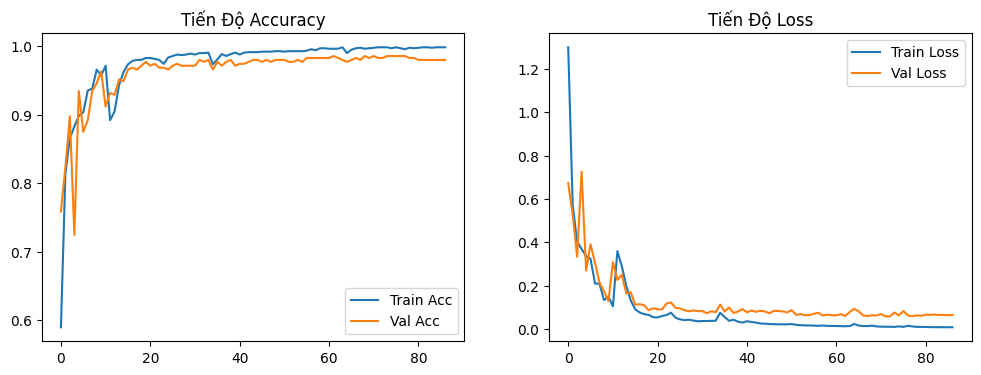

In [7]:
# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Classification Report
print("\nClassification Report (Precision/Recall/F1):")
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder))



# Plot History - Tiến Độ Huấn Luyện
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Tiến Độ Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Tiến Độ Loss')
plt.legend()
plt.show()